# CIFAR10 with CNNs

Scores do modelo original:

 {'accuracy': 0.7136, 'balanced_accuracy': np.float64(0.7136000000000001), 'precision': 0.7141355730287995, 'recall': 0.7136, 'f1_score': 0.7133133029149751}

In [ ]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

In [ ]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,  transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,  transform=transform)

classes = test_dataset.classes

100%|██████████| 170M/170M [00:04<00:00, 41.3MB/s]


Gera val_dataset como subset balanceado de train_val_dataset


In [ ]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [ ]:
def makeLoaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Visualizar imagens

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [ ]:
# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

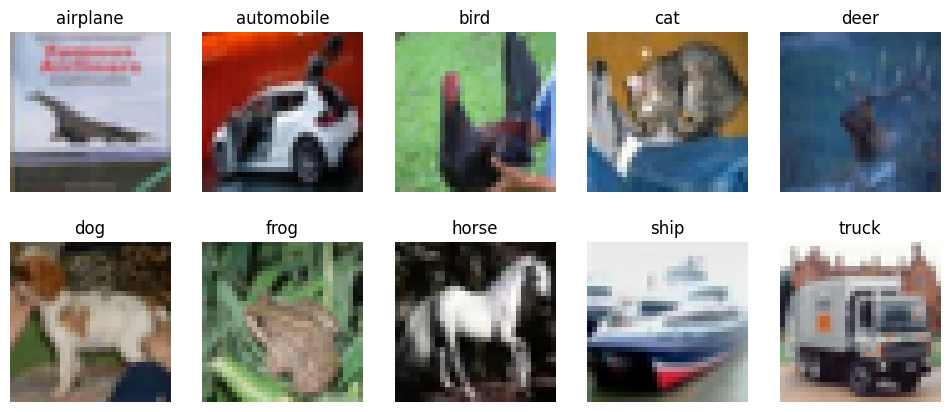

In [ ]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

### Defining the CNN model
Here we adapt the LeNet-5 architecture introduced in [*Gradient-based learning applied to document recognition*](https://ieeexplore.ieee.org/document/726791), originally developed to classify handwritten digits.

![lenet5](https://www.researchgate.net/publication/359784095/figure/fig2/AS:11431281079624737@1660789284522/Example-of-a-CNN-LeNet-5-14-is-able-to-identify-handwritten-digits-for-zip-code.png)


The main change we made here is the number of in/out channels, kernel sizes, padding, etc (enabling better results). It has 2 convolutional layers followed by 2 pooling (subsampling) layers. After the conv. blocks, we pass the feature maps through 2 hidden fully-connected layers to get the most activated neuron with the softmax function. If you want a more detailed explanation, [check this link](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/) or reach us on Discord :)

In [ ]:
class FlexibleCNN(nn.Module):
    """
    Uma classe de CNN flexível com entrada para imagens de 3 canais e 32x32 pixels.
    """
    def __init__(self, config):
        super(FlexibleCNN, self).__init__()
        self.config = config

        # Valores de entrada fixos
        initial_in_channels = 3
        img_height = 32
        img_width = 32

        # 1. Camadas de extração de características
        features_layers = []
        in_channels = initial_in_channels # Começa com o valor inicial

        for out_channels, k, s, p in self.config['conv_layers']:
            features_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=k,
                    stride=s,
                    padding=p
                )
            )
            features_layers.append(nn.ReLU())
            if self.config.get('pool_kernel_size'):
                features_layers.append(
                    nn.MaxPool2d(
                        kernel_size=self.config['pool_kernel_size'],
                        stride=self.config.get('pool_stride', self.config['pool_kernel_size'])
                    )
                )
            in_channels = out_channels # Atualiza para a próxima camada do loop

        self.features = nn.Sequential(*features_layers)

        # 2. Calcular o tamanho da saída do extrator de features
        with torch.no_grad():
            dummy_input = torch.zeros(1, initial_in_channels, img_height, img_width)
            dummy_output = self.features(dummy_input)
            self.flattened_features_size = dummy_output.view(-1).shape[0]

        # 3. Construir o Classificador
        classifier_layers = []
        in_features = self.flattened_features_size

        for out_features, dropout_rate in self.config.get('fc_layers', []):
            classifier_layers.append(nn.Linear(in_features, out_features))
            classifier_layers.append(nn.ReLU())
            if dropout_rate > 0:
                classifier_layers.append(nn.Dropout(p=dropout_rate))
            in_features = out_features

        classifier_layers.append(nn.Linear(in_features, self.config['output_size']))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        # O assert foi removido para simplificar, mas pode ser útil para debug
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Evaluation helper functions

In [ ]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [ ]:
def evaluate(net, loader, loss_function):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [ ]:
#@title Evaluate model (accuracy, precision, recall, etc)

def makePredictions(net, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

In [ ]:
def plotLoss(train_losses, val_losses):
    plt.plot(train_losses, label='Treinamento')
    plt.plot(val_losses, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

## Train Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses

## Experiment 1

In [ ]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5

In [ ]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model1 = FlexibleCNN(config1)

In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trained_CNN, train_losses, val_losses = train_model(model1,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:17<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.0847


  2%|▏         | 1/50 [00:26<21:27, 26.27s/it]

Epoch 1 completed. Train Loss: 1.3818 | Val Loss: 1.1235


  2%|▏         | 1/50 [00:43<21:27, 26.27s/it]

Epoch 2/50, Step 1000/1250, Loss: 0.6318


  4%|▍         | 2/50 [00:51<20:27, 25.57s/it]

Epoch 2 completed. Train Loss: 0.9913 | Val Loss: 0.9895


  4%|▍         | 2/50 [01:07<20:27, 25.57s/it]

Epoch 3/50, Step 1000/1250, Loss: 0.9587


  6%|▌         | 3/50 [01:16<19:50, 25.33s/it]

Epoch 3 completed. Train Loss: 0.8217 | Val Loss: 0.8844


  6%|▌         | 3/50 [01:33<19:50, 25.33s/it]

Epoch 4/50, Step 1000/1250, Loss: 0.4812


  8%|▊         | 4/50 [01:41<19:12, 25.05s/it]

Epoch 4 completed. Train Loss: 0.7038 | Val Loss: 0.8535


  8%|▊         | 4/50 [01:56<19:12, 25.05s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7709


 10%|█         | 5/50 [02:05<18:35, 24.78s/it]

Epoch 5 completed. Train Loss: 0.5957 | Val Loss: 0.9403


 10%|█         | 5/50 [02:21<18:35, 24.78s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.7013


 12%|█▏        | 6/50 [02:30<18:10, 24.79s/it]

Epoch 6 completed. Train Loss: 0.5004 | Val Loss: 0.8795


 12%|█▏        | 6/50 [02:46<18:10, 24.79s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.6888


 14%|█▍        | 7/50 [02:55<17:58, 25.07s/it]

Epoch 7 completed. Train Loss: 0.4138 | Val Loss: 0.9305


 14%|█▍        | 7/50 [03:12<17:58, 25.07s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.2996


 16%|█▌        | 8/50 [03:21<17:41, 25.27s/it]

Epoch 8 completed. Train Loss: 0.3401 | Val Loss: 1.0136


 16%|█▌        | 8/50 [03:38<17:41, 25.27s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.1819


 16%|█▌        | 8/50 [03:47<19:54, 28.44s/it]

Epoch 9 completed. Train Loss: 0.2706 | Val Loss: 1.1412
Early stopping at epoch 9


## Experiment 1 results

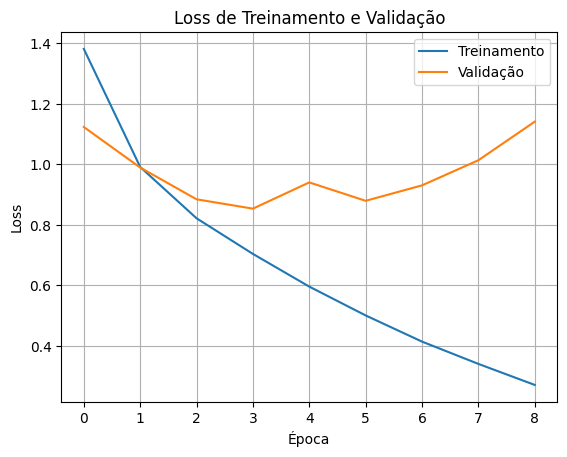

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
torch.save(model1.state_dict(), "model1_trained2.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = FlexibleCNN(config1)
model1.to(device)

model1.load_state_dict(torch.load("model1_trained.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
#@title Evaluate model (accuracy, precision, recall, etc)
labels, predictions = makePredictions(model1, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


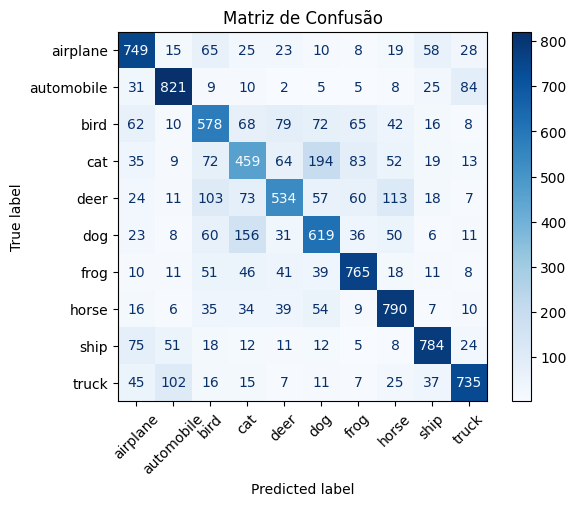

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 2

Diminuir o learning rate

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model2 = FlexibleCNN(config1)

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:12<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.5811


  2%|▏         | 1/50 [00:17<14:33, 17.83s/it]

Epoch 1 completed. Train Loss: 1.7610 | Val Loss: 1.5436


  2%|▏         | 1/50 [00:29<14:33, 17.83s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.3359


  4%|▍         | 2/50 [00:34<13:49, 17.29s/it]

Epoch 2 completed. Train Loss: 1.4540 | Val Loss: 1.3899


  4%|▍         | 2/50 [00:45<13:49, 17.29s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.2491


  6%|▌         | 3/50 [00:51<13:23, 17.09s/it]

Epoch 3 completed. Train Loss: 1.3465 | Val Loss: 1.3112


  6%|▌         | 3/50 [01:03<13:23, 17.09s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.4880


  8%|▊         | 4/50 [01:08<13:06, 17.09s/it]

Epoch 4 completed. Train Loss: 1.2668 | Val Loss: 1.2551


  8%|▊         | 4/50 [01:19<13:06, 17.09s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7146


 10%|█         | 5/50 [01:25<12:47, 17.05s/it]

Epoch 5 completed. Train Loss: 1.2023 | Val Loss: 1.1940


 10%|█         | 5/50 [01:37<12:47, 17.05s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.9474


 12%|█▏        | 6/50 [01:42<12:30, 17.05s/it]

Epoch 6 completed. Train Loss: 1.1465 | Val Loss: 1.1402


 12%|█▏        | 6/50 [01:54<12:30, 17.05s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.8789


 14%|█▍        | 7/50 [01:59<12:15, 17.10s/it]

Epoch 7 completed. Train Loss: 1.0930 | Val Loss: 1.1132


 14%|█▍        | 7/50 [02:11<12:15, 17.10s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.9707


 16%|█▌        | 8/50 [02:16<11:54, 17.01s/it]

Epoch 8 completed. Train Loss: 1.0452 | Val Loss: 1.0843


 16%|█▌        | 8/50 [02:28<11:54, 17.01s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.6057


 18%|█▊        | 9/50 [02:33<11:38, 17.03s/it]

Epoch 9 completed. Train Loss: 1.0034 | Val Loss: 1.0469


 18%|█▊        | 9/50 [02:45<11:38, 17.03s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.3411


 20%|██        | 10/50 [02:50<11:21, 17.04s/it]

Epoch 10 completed. Train Loss: 0.9646 | Val Loss: 1.0307


 20%|██        | 10/50 [03:02<11:21, 17.04s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.9521


 22%|██▏       | 11/50 [03:07<11:02, 16.98s/it]

Epoch 11 completed. Train Loss: 0.9273 | Val Loss: 0.9976


 22%|██▏       | 11/50 [03:18<11:02, 16.98s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.6940


 24%|██▍       | 12/50 [03:24<10:44, 16.96s/it]

Epoch 12 completed. Train Loss: 0.8947 | Val Loss: 0.9962


 24%|██▍       | 12/50 [03:35<10:44, 16.96s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.7141


 26%|██▌       | 13/50 [03:41<10:26, 16.94s/it]

Epoch 13 completed. Train Loss: 0.8645 | Val Loss: 0.9651


 26%|██▌       | 13/50 [03:52<10:26, 16.94s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.6127


 28%|██▊       | 14/50 [03:58<10:10, 16.95s/it]

Epoch 14 completed. Train Loss: 0.8354 | Val Loss: 0.9561


 28%|██▊       | 14/50 [04:09<10:10, 16.95s/it]

Epoch 15/50, Step 1000/1250, Loss: 0.7730


 30%|███       | 15/50 [04:15<09:51, 16.91s/it]

Epoch 15 completed. Train Loss: 0.8086 | Val Loss: 0.9339


 30%|███       | 15/50 [04:26<09:51, 16.91s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.5296


 32%|███▏      | 16/50 [04:32<09:34, 16.89s/it]

Epoch 16 completed. Train Loss: 0.7838 | Val Loss: 0.9557


 32%|███▏      | 16/50 [04:43<09:34, 16.89s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.7410


 34%|███▍      | 17/50 [04:48<09:15, 16.85s/it]

Epoch 17 completed. Train Loss: 0.7591 | Val Loss: 0.9256


 34%|███▍      | 17/50 [05:00<09:15, 16.85s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.6086


 36%|███▌      | 18/50 [05:05<08:59, 16.86s/it]

Epoch 18 completed. Train Loss: 0.7353 | Val Loss: 0.9160


 36%|███▌      | 18/50 [05:17<08:59, 16.86s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.7741


 38%|███▊      | 19/50 [05:22<08:44, 16.90s/it]

Epoch 19 completed. Train Loss: 0.7118 | Val Loss: 0.9095


 38%|███▊      | 19/50 [05:34<08:44, 16.90s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.5819


 40%|████      | 20/50 [05:39<08:27, 16.93s/it]

Epoch 20 completed. Train Loss: 0.6885 | Val Loss: 0.9085


 40%|████      | 20/50 [05:50<08:27, 16.93s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.4198


 42%|████▏     | 21/50 [05:56<08:08, 16.84s/it]

Epoch 21 completed. Train Loss: 0.6658 | Val Loss: 0.9132


 42%|████▏     | 21/50 [06:07<08:08, 16.84s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7405


 44%|████▍     | 22/50 [06:13<07:51, 16.83s/it]

Epoch 22 completed. Train Loss: 0.6424 | Val Loss: 0.9077


 44%|████▍     | 22/50 [06:24<07:51, 16.83s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.5145


 46%|████▌     | 23/50 [06:29<07:33, 16.78s/it]

Epoch 23 completed. Train Loss: 0.6228 | Val Loss: 0.9235


 46%|████▌     | 23/50 [06:41<07:33, 16.78s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.8067


 48%|████▊     | 24/50 [06:46<07:15, 16.73s/it]

Epoch 24 completed. Train Loss: 0.6031 | Val Loss: 0.9059


 48%|████▊     | 24/50 [06:57<07:15, 16.73s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.7158


 50%|█████     | 25/50 [07:03<06:57, 16.69s/it]

Epoch 25 completed. Train Loss: 0.5804 | Val Loss: 0.9079


 50%|█████     | 25/50 [07:14<06:57, 16.69s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.5276


 52%|█████▏    | 26/50 [07:19<06:38, 16.61s/it]

Epoch 26 completed. Train Loss: 0.5591 | Val Loss: 0.9417


 52%|█████▏    | 26/50 [07:30<06:38, 16.61s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.4083


 54%|█████▍    | 27/50 [07:36<06:22, 16.63s/it]

Epoch 27 completed. Train Loss: 0.5400 | Val Loss: 0.9326


 54%|█████▍    | 27/50 [07:47<06:22, 16.63s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.5458


 56%|█████▌    | 28/50 [07:53<06:07, 16.71s/it]

Epoch 28 completed. Train Loss: 0.5194 | Val Loss: 0.9589


 56%|█████▌    | 28/50 [08:04<06:07, 16.71s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6419


 56%|█████▌    | 28/50 [08:10<06:25, 17.51s/it]

Epoch 29 completed. Train Loss: 0.4981 | Val Loss: 0.9436
Early stopping at epoch 29


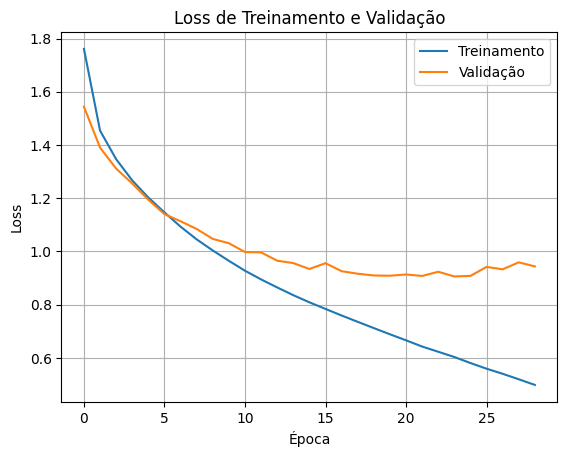

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment 3

Adicionar dropout para diminuir o overfitting

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config2 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

# Criando o modelo
model3 = FlexibleCNN(config2)

optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model3,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:11<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.5667


  2%|▏         | 1/50 [00:16<13:48, 16.90s/it]

Epoch 1 completed. Train Loss: 1.8439 | Val Loss: 1.5538


  2%|▏         | 1/50 [00:28<13:48, 16.90s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.5844


  4%|▍         | 2/50 [00:34<13:56, 17.42s/it]

Epoch 2 completed. Train Loss: 1.5274 | Val Loss: 1.3970


  4%|▍         | 2/50 [00:46<13:56, 17.42s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.2377


  6%|▌         | 3/50 [00:52<13:43, 17.52s/it]

Epoch 3 completed. Train Loss: 1.4188 | Val Loss: 1.3137


  6%|▌         | 3/50 [01:03<13:43, 17.52s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.6308


  8%|▊         | 4/50 [01:09<13:19, 17.39s/it]

Epoch 4 completed. Train Loss: 1.3390 | Val Loss: 1.2548


  8%|▊         | 4/50 [01:20<13:19, 17.39s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3819


 10%|█         | 5/50 [01:26<12:50, 17.13s/it]

Epoch 5 completed. Train Loss: 1.2822 | Val Loss: 1.2287


 10%|█         | 5/50 [01:37<12:50, 17.13s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.8351


 12%|█▏        | 6/50 [01:42<12:25, 16.94s/it]

Epoch 6 completed. Train Loss: 1.2266 | Val Loss: 1.1450


 12%|█▏        | 6/50 [01:53<12:25, 16.94s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.5058


 14%|█▍        | 7/50 [01:59<12:04, 16.85s/it]

Epoch 7 completed. Train Loss: 1.1772 | Val Loss: 1.1295


 14%|█▍        | 7/50 [02:10<12:04, 16.85s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.8592


 16%|█▌        | 8/50 [02:16<11:45, 16.79s/it]

Epoch 8 completed. Train Loss: 1.1342 | Val Loss: 1.0799


 16%|█▌        | 8/50 [02:27<11:45, 16.79s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.2255


 18%|█▊        | 9/50 [02:32<11:24, 16.70s/it]

Epoch 9 completed. Train Loss: 1.0939 | Val Loss: 1.0429


 18%|█▊        | 9/50 [02:43<11:24, 16.70s/it]

Epoch 10/50, Step 1000/1250, Loss: 0.9510


 20%|██        | 10/50 [02:48<11:03, 16.60s/it]

Epoch 10 completed. Train Loss: 1.0574 | Val Loss: 1.0479


 20%|██        | 10/50 [02:59<11:03, 16.60s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.8078


 22%|██▏       | 11/50 [03:05<10:45, 16.54s/it]

Epoch 11 completed. Train Loss: 1.0225 | Val Loss: 1.0002


 22%|██▏       | 11/50 [03:16<10:45, 16.54s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.4551


 24%|██▍       | 12/50 [03:21<10:28, 16.54s/it]

Epoch 12 completed. Train Loss: 0.9875 | Val Loss: 0.9871


 24%|██▍       | 12/50 [03:32<10:28, 16.54s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.9081


 26%|██▌       | 13/50 [03:38<10:12, 16.55s/it]

Epoch 13 completed. Train Loss: 0.9626 | Val Loss: 0.9662


 26%|██▌       | 13/50 [03:50<10:12, 16.55s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.7623


 28%|██▊       | 14/50 [03:55<10:05, 16.81s/it]

Epoch 14 completed. Train Loss: 0.9323 | Val Loss: 0.9660


 28%|██▊       | 14/50 [04:07<10:05, 16.81s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0897


 30%|███       | 15/50 [04:13<09:51, 16.91s/it]

Epoch 15 completed. Train Loss: 0.9029 | Val Loss: 0.9334


 30%|███       | 15/50 [04:24<09:51, 16.91s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.6132


 32%|███▏      | 16/50 [04:30<09:35, 16.94s/it]

Epoch 16 completed. Train Loss: 0.8810 | Val Loss: 0.9370


 32%|███▏      | 16/50 [04:41<09:35, 16.94s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.9251


 34%|███▍      | 17/50 [04:46<09:14, 16.81s/it]

Epoch 17 completed. Train Loss: 0.8574 | Val Loss: 0.9103


 34%|███▍      | 17/50 [04:57<09:14, 16.81s/it]

Epoch 18/50, Step 1000/1250, Loss: 1.1147


 36%|███▌      | 18/50 [05:03<08:55, 16.75s/it]

Epoch 18 completed. Train Loss: 0.8294 | Val Loss: 0.9036


 36%|███▌      | 18/50 [05:14<08:55, 16.75s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.8921


 38%|███▊      | 19/50 [05:19<08:37, 16.70s/it]

Epoch 19 completed. Train Loss: 0.8092 | Val Loss: 0.9028


 38%|███▊      | 19/50 [05:30<08:37, 16.70s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.7207


 40%|████      | 20/50 [05:36<08:18, 16.63s/it]

Epoch 20 completed. Train Loss: 0.7909 | Val Loss: 0.8880


 40%|████      | 20/50 [05:47<08:18, 16.63s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.7204


 42%|████▏     | 21/50 [05:52<07:59, 16.55s/it]

Epoch 21 completed. Train Loss: 0.7675 | Val Loss: 0.8917


 42%|████▏     | 21/50 [06:03<07:59, 16.55s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.8035


 44%|████▍     | 22/50 [06:08<07:40, 16.46s/it]

Epoch 22 completed. Train Loss: 0.7499 | Val Loss: 0.8733


 44%|████▍     | 22/50 [06:19<07:40, 16.46s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.7199


 46%|████▌     | 23/50 [06:25<07:24, 16.47s/it]

Epoch 23 completed. Train Loss: 0.7220 | Val Loss: 0.8768


 46%|████▌     | 23/50 [06:36<07:24, 16.47s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6686


 48%|████▊     | 24/50 [06:41<07:09, 16.53s/it]

Epoch 24 completed. Train Loss: 0.7071 | Val Loss: 0.8726


 48%|████▊     | 24/50 [06:52<07:09, 16.53s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.4286


 50%|█████     | 25/50 [06:58<06:52, 16.48s/it]

Epoch 25 completed. Train Loss: 0.6893 | Val Loss: 0.8862


 50%|█████     | 25/50 [07:09<06:52, 16.48s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.7701


 52%|█████▏    | 26/50 [07:14<06:33, 16.41s/it]

Epoch 26 completed. Train Loss: 0.6696 | Val Loss: 0.8701


 52%|█████▏    | 26/50 [07:25<06:33, 16.41s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.7747


 54%|█████▍    | 27/50 [07:30<06:16, 16.37s/it]

Epoch 27 completed. Train Loss: 0.6426 | Val Loss: 0.8682


 54%|█████▍    | 27/50 [07:41<06:16, 16.37s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.7360


 56%|█████▌    | 28/50 [07:47<06:01, 16.43s/it]

Epoch 28 completed. Train Loss: 0.6297 | Val Loss: 0.8665


 56%|█████▌    | 28/50 [07:58<06:01, 16.43s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6490


 58%|█████▊    | 29/50 [08:04<05:46, 16.50s/it]

Epoch 29 completed. Train Loss: 0.6093 | Val Loss: 0.8647


 58%|█████▊    | 29/50 [08:15<05:46, 16.50s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.6459


 60%|██████    | 30/50 [08:20<05:29, 16.46s/it]

Epoch 30 completed. Train Loss: 0.5916 | Val Loss: 0.8741


 60%|██████    | 30/50 [08:31<05:29, 16.46s/it]

Epoch 31/50, Step 1000/1250, Loss: 0.4459


 62%|██████▏   | 31/50 [08:36<05:11, 16.41s/it]

Epoch 31 completed. Train Loss: 0.5737 | Val Loss: 0.8678


 62%|██████▏   | 31/50 [08:47<05:11, 16.41s/it]

Epoch 32/50, Step 1000/1250, Loss: 0.6674


 64%|██████▍   | 32/50 [08:53<04:56, 16.48s/it]

Epoch 32 completed. Train Loss: 0.5502 | Val Loss: 0.8851


 64%|██████▍   | 32/50 [09:04<04:56, 16.48s/it]

Epoch 33/50, Step 1000/1250, Loss: 0.3232


 66%|██████▌   | 33/50 [09:10<04:42, 16.61s/it]

Epoch 33 completed. Train Loss: 0.5426 | Val Loss: 0.8834


 66%|██████▌   | 33/50 [09:21<04:42, 16.61s/it]

Epoch 34/50, Step 1000/1250, Loss: 0.2317


 66%|██████▌   | 33/50 [09:26<04:51, 17.17s/it]

Epoch 34 completed. Train Loss: 0.5203 | Val Loss: 0.9071
Early stopping at epoch 34


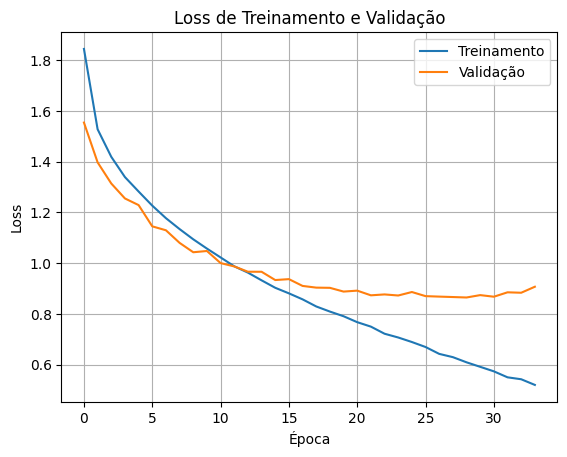

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experimento AM1

Pego o experimento 1 é aumentando apenas o bach_size para 128

In [ ]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 50
batch_size = 128
patience = 5

In [ ]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model1 = FlexibleCNN(config1)

In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trained_CNN, train_losses, val_losses = train_model(model1,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  2%|▏         | 1/50 [00:13<11:12, 13.72s/it]

Epoch 1 completed. Train Loss: 1.5203 | Val Loss: 1.2567


  4%|▍         | 2/50 [00:26<10:44, 13.43s/it]

Epoch 2 completed. Train Loss: 1.1367 | Val Loss: 1.0686


  6%|▌         | 3/50 [00:40<10:30, 13.43s/it]

Epoch 3 completed. Train Loss: 0.9750 | Val Loss: 0.9476


  8%|▊         | 4/50 [00:53<10:16, 13.41s/it]

Epoch 4 completed. Train Loss: 0.8573 | Val Loss: 0.9016


 10%|█         | 5/50 [01:06<09:57, 13.27s/it]

Epoch 5 completed. Train Loss: 0.7690 | Val Loss: 0.9569


 12%|█▏        | 6/50 [01:19<09:41, 13.21s/it]

Epoch 6 completed. Train Loss: 0.6810 | Val Loss: 0.9030


 14%|█▍        | 7/50 [01:33<09:31, 13.29s/it]

Epoch 7 completed. Train Loss: 0.5982 | Val Loss: 0.8627


 16%|█▌        | 8/50 [01:46<09:15, 13.22s/it]

Epoch 8 completed. Train Loss: 0.5203 | Val Loss: 0.8832


 18%|█▊        | 9/50 [01:59<08:58, 13.13s/it]

Epoch 9 completed. Train Loss: 0.4451 | Val Loss: 0.9257


 20%|██        | 10/50 [02:12<08:49, 13.23s/it]

Epoch 10 completed. Train Loss: 0.3702 | Val Loss: 1.0038


 22%|██▏       | 11/50 [02:25<08:34, 13.20s/it]

Epoch 11 completed. Train Loss: 0.3060 | Val Loss: 1.0394


 22%|██▏       | 11/50 [02:38<09:23, 14.45s/it]

Epoch 12 completed. Train Loss: 0.2437 | Val Loss: 1.1220
Early stopping at epoch 12


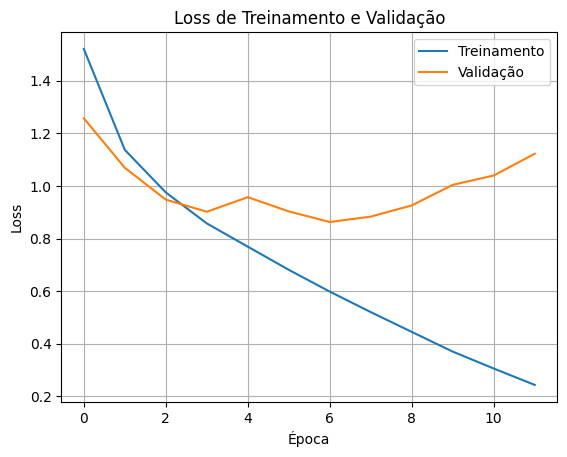

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
torch.save(model1.state_dict(), "model1_trained2.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = FlexibleCNN(config1)
model1.to(device)

model1.load_state_dict(torch.load("model1_trained2.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
#@title Evaluate model (accuracy, precision, recall, etc)
labels, predictions = makePredictions(model1, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7058, 'balanced_accuracy': np.float64(0.7058), 'precision': 0.7071710026655305, 'recall': 0.7058, 'f1_score': 0.705002459714131}


Houve um aumento de 2% percentual ao experimento 1

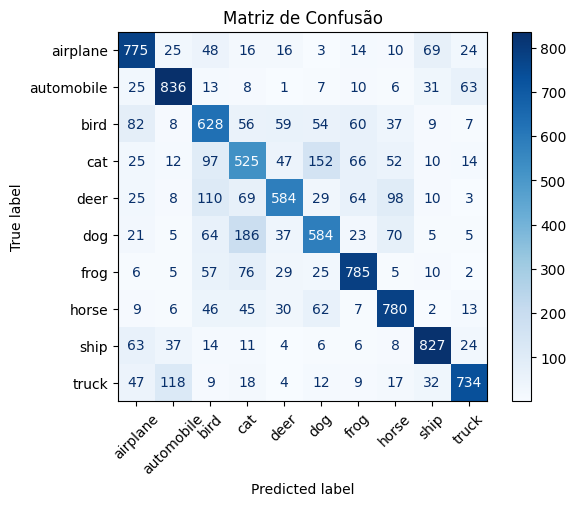

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experimento AM2


Pegado mudanças do experimento 3 e aumentado o batch_size para 64

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 64
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config3 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

# Criando o modelo
model4 = FlexibleCNN(config3)

optimizer = optim.Adam(model4.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model4,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  2%|▏         | 1/50 [00:15<12:27, 15.25s/it]

Epoch 1 completed. Train Loss: 1.9088 | Val Loss: 1.6134


  4%|▍         | 2/50 [00:29<11:40, 14.59s/it]

Epoch 2 completed. Train Loss: 1.6128 | Val Loss: 1.4723


  6%|▌         | 3/50 [00:43<11:12, 14.32s/it]

Epoch 3 completed. Train Loss: 1.5020 | Val Loss: 1.3891


  8%|▊         | 4/50 [00:57<10:50, 14.15s/it]

Epoch 4 completed. Train Loss: 1.4279 | Val Loss: 1.3460


 10%|█         | 5/50 [01:11<10:32, 14.05s/it]

Epoch 5 completed. Train Loss: 1.3715 | Val Loss: 1.2840


 12%|█▏        | 6/50 [01:25<10:20, 14.11s/it]

Epoch 6 completed. Train Loss: 1.3134 | Val Loss: 1.2399


 14%|█▍        | 7/50 [01:39<10:09, 14.16s/it]

Epoch 7 completed. Train Loss: 1.2687 | Val Loss: 1.1980


 16%|█▌        | 8/50 [01:53<09:54, 14.15s/it]

Epoch 8 completed. Train Loss: 1.2258 | Val Loss: 1.1676


 18%|█▊        | 9/50 [02:07<09:41, 14.17s/it]

Epoch 9 completed. Train Loss: 1.1901 | Val Loss: 1.1525


 20%|██        | 10/50 [02:22<09:26, 14.16s/it]

Epoch 10 completed. Train Loss: 1.1519 | Val Loss: 1.1120


 22%|██▏       | 11/50 [02:36<09:10, 14.12s/it]

Epoch 11 completed. Train Loss: 1.1209 | Val Loss: 1.0849


 24%|██▍       | 12/50 [02:50<08:59, 14.21s/it]

Epoch 12 completed. Train Loss: 1.0914 | Val Loss: 1.0631


 26%|██▌       | 13/50 [03:04<08:45, 14.19s/it]

Epoch 13 completed. Train Loss: 1.0624 | Val Loss: 1.0366


 28%|██▊       | 14/50 [03:18<08:30, 14.17s/it]

Epoch 14 completed. Train Loss: 1.0390 | Val Loss: 1.0238


 30%|███       | 15/50 [03:32<08:15, 14.16s/it]

Epoch 15 completed. Train Loss: 1.0127 | Val Loss: 1.0071


 32%|███▏      | 16/50 [03:46<07:59, 14.11s/it]

Epoch 16 completed. Train Loss: 0.9890 | Val Loss: 0.9967


 34%|███▍      | 17/50 [04:01<07:48, 14.19s/it]

Epoch 17 completed. Train Loss: 0.9658 | Val Loss: 0.9737


 36%|███▌      | 18/50 [04:15<07:33, 14.17s/it]

Epoch 18 completed. Train Loss: 0.9481 | Val Loss: 0.9740


 38%|███▊      | 19/50 [04:29<07:19, 14.17s/it]

Epoch 19 completed. Train Loss: 0.9233 | Val Loss: 0.9640


 40%|████      | 20/50 [04:43<06:58, 13.95s/it]

Epoch 20 completed. Train Loss: 0.9027 | Val Loss: 0.9517


 42%|████▏     | 21/50 [04:56<06:40, 13.80s/it]

Epoch 21 completed. Train Loss: 0.8823 | Val Loss: 0.9315


 44%|████▍     | 22/50 [05:10<06:25, 13.77s/it]

Epoch 22 completed. Train Loss: 0.8642 | Val Loss: 0.9205


 46%|████▌     | 23/50 [05:24<06:16, 13.95s/it]

Epoch 23 completed. Train Loss: 0.8425 | Val Loss: 0.9161


 48%|████▊     | 24/50 [05:38<06:04, 14.03s/it]

Epoch 24 completed. Train Loss: 0.8276 | Val Loss: 0.9081


 50%|█████     | 25/50 [05:52<05:50, 14.01s/it]

Epoch 25 completed. Train Loss: 0.8101 | Val Loss: 0.8972


 52%|█████▏    | 26/50 [06:06<05:35, 13.97s/it]

Epoch 26 completed. Train Loss: 0.7900 | Val Loss: 0.9023


 54%|█████▍    | 27/50 [06:20<05:19, 13.88s/it]

Epoch 27 completed. Train Loss: 0.7763 | Val Loss: 0.8871


 56%|█████▌    | 28/50 [06:34<05:06, 13.93s/it]

Epoch 28 completed. Train Loss: 0.7547 | Val Loss: 0.8984


 58%|█████▊    | 29/50 [06:48<04:56, 14.14s/it]

Epoch 29 completed. Train Loss: 0.7432 | Val Loss: 0.8933


 60%|██████    | 30/50 [07:02<04:41, 14.08s/it]

Epoch 30 completed. Train Loss: 0.7257 | Val Loss: 0.8844


 62%|██████▏   | 31/50 [07:16<04:25, 13.98s/it]

Epoch 31 completed. Train Loss: 0.7120 | Val Loss: 0.8727


 64%|██████▍   | 32/50 [07:30<04:10, 13.92s/it]

Epoch 32 completed. Train Loss: 0.6913 | Val Loss: 0.8818


 66%|██████▌   | 33/50 [07:44<03:56, 13.90s/it]

Epoch 33 completed. Train Loss: 0.6809 | Val Loss: 0.8700


 68%|██████▊   | 34/50 [07:58<03:41, 13.85s/it]

Epoch 34 completed. Train Loss: 0.6621 | Val Loss: 0.8759


 70%|███████   | 35/50 [08:12<03:31, 14.09s/it]

Epoch 35 completed. Train Loss: 0.6469 | Val Loss: 0.8845


 72%|███████▏  | 36/50 [08:26<03:16, 14.04s/it]

Epoch 36 completed. Train Loss: 0.6346 | Val Loss: 0.8657


 74%|███████▍  | 37/50 [08:40<03:02, 14.02s/it]

Epoch 37 completed. Train Loss: 0.6216 | Val Loss: 0.8733


 76%|███████▌  | 38/50 [08:54<02:48, 14.03s/it]

Epoch 38 completed. Train Loss: 0.6095 | Val Loss: 0.8788


 78%|███████▊  | 39/50 [09:08<02:33, 13.98s/it]

Epoch 39 completed. Train Loss: 0.5941 | Val Loss: 0.8736


 80%|████████  | 40/50 [09:22<02:20, 14.03s/it]

Epoch 40 completed. Train Loss: 0.5788 | Val Loss: 0.8744


 80%|████████  | 40/50 [09:36<02:24, 14.42s/it]

Epoch 41 completed. Train Loss: 0.5641 | Val Loss: 0.8770
Early stopping at epoch 41


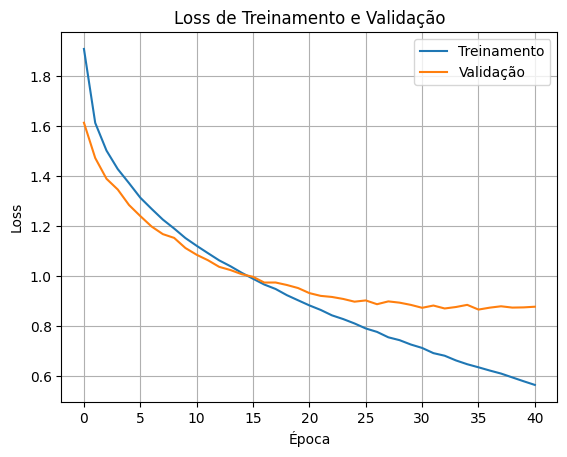

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model4, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7089, 'balanced_accuracy': np.float64(0.7089), 'precision': 0.7084632229248892, 'recall': 0.7089, 'f1_score': 0.7068026615012711}


Foi constado uma pequena melhoria para o experimento 3 (que tem uma acurácia de 69.3)

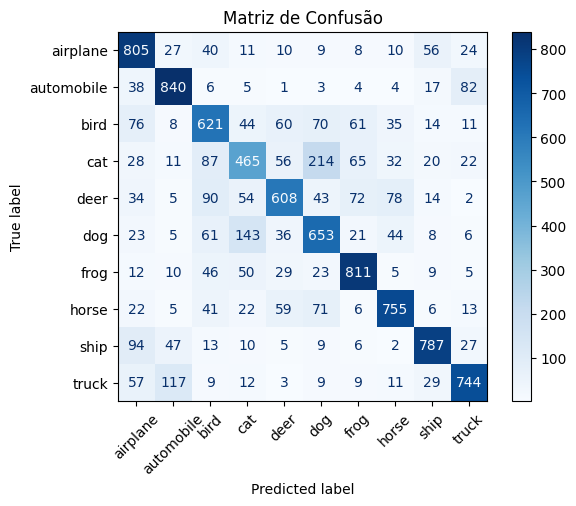

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experimento AM3

Dado o experimento AM2, manter tudo igual e aumentar ainda mais o batch_size -- para 256.

In [ ]:
learning_rate = 0.0001
num_epochs = 100
batch_size = 256
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config3 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

# Criando o modelo
model4 = FlexibleCNN(config3)

optimizer = optim.Adam(model4.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model4,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  1%|          | 1/100 [00:13<21:51, 13.25s/it]

Epoch 1 completed. Train Loss: 2.0515 | Val Loss: 1.8290


  2%|▏         | 2/100 [00:26<21:37, 13.24s/it]

Epoch 2 completed. Train Loss: 1.7819 | Val Loss: 1.6254


  3%|▎         | 3/100 [00:39<21:20, 13.21s/it]

Epoch 3 completed. Train Loss: 1.6336 | Val Loss: 1.5351


  4%|▍         | 4/100 [00:53<21:17, 13.31s/it]

Epoch 4 completed. Train Loss: 1.5480 | Val Loss: 1.4543


  5%|▌         | 5/100 [01:06<21:16, 13.44s/it]

Epoch 5 completed. Train Loss: 1.4982 | Val Loss: 1.4230


  6%|▌         | 6/100 [01:20<20:58, 13.39s/it]

Epoch 6 completed. Train Loss: 1.4594 | Val Loss: 1.3813


  7%|▋         | 7/100 [01:33<20:36, 13.30s/it]

Epoch 7 completed. Train Loss: 1.4176 | Val Loss: 1.3483


  8%|▊         | 8/100 [01:46<20:15, 13.21s/it]

Epoch 8 completed. Train Loss: 1.3842 | Val Loss: 1.3057


  9%|▉         | 9/100 [01:59<19:58, 13.18s/it]

Epoch 9 completed. Train Loss: 1.3541 | Val Loss: 1.2867


 10%|█         | 10/100 [02:12<19:44, 13.16s/it]

Epoch 10 completed. Train Loss: 1.3326 | Val Loss: 1.2654


 11%|█         | 11/100 [02:25<19:26, 13.10s/it]

Epoch 11 completed. Train Loss: 1.3019 | Val Loss: 1.2552


 12%|█▏        | 12/100 [02:38<19:08, 13.05s/it]

Epoch 12 completed. Train Loss: 1.2790 | Val Loss: 1.2302


 13%|█▎        | 13/100 [02:51<18:48, 12.97s/it]

Epoch 13 completed. Train Loss: 1.2599 | Val Loss: 1.2034


 14%|█▍        | 14/100 [03:03<18:30, 12.91s/it]

Epoch 14 completed. Train Loss: 1.2367 | Val Loss: 1.1954


 15%|█▌        | 15/100 [03:16<18:21, 12.95s/it]

Epoch 15 completed. Train Loss: 1.2138 | Val Loss: 1.1700


 16%|█▌        | 16/100 [03:30<18:10, 12.99s/it]

Epoch 16 completed. Train Loss: 1.1954 | Val Loss: 1.1486


 17%|█▋        | 17/100 [03:42<17:50, 12.89s/it]

Epoch 17 completed. Train Loss: 1.1736 | Val Loss: 1.1329


 18%|█▊        | 18/100 [03:55<17:32, 12.84s/it]

Epoch 18 completed. Train Loss: 1.1598 | Val Loss: 1.1179


 19%|█▉        | 19/100 [04:08<17:17, 12.81s/it]

Epoch 19 completed. Train Loss: 1.1397 | Val Loss: 1.1114


 20%|██        | 20/100 [04:20<16:59, 12.75s/it]

Epoch 20 completed. Train Loss: 1.1245 | Val Loss: 1.1012


 21%|██        | 21/100 [04:33<16:46, 12.74s/it]

Epoch 21 completed. Train Loss: 1.1122 | Val Loss: 1.0771


 22%|██▏       | 22/100 [04:46<16:39, 12.82s/it]

Epoch 22 completed. Train Loss: 1.0936 | Val Loss: 1.0833


 23%|██▎       | 23/100 [04:59<16:25, 12.80s/it]

Epoch 23 completed. Train Loss: 1.0793 | Val Loss: 1.0689


 24%|██▍       | 24/100 [05:11<16:10, 12.77s/it]

Epoch 24 completed. Train Loss: 1.0658 | Val Loss: 1.0698


 25%|██▌       | 25/100 [05:24<15:57, 12.76s/it]

Epoch 25 completed. Train Loss: 1.0486 | Val Loss: 1.0373


 26%|██▌       | 26/100 [05:37<15:49, 12.83s/it]

Epoch 26 completed. Train Loss: 1.0347 | Val Loss: 1.0508


 27%|██▋       | 27/100 [05:50<15:41, 12.90s/it]

Epoch 27 completed. Train Loss: 1.0249 | Val Loss: 1.0228


 28%|██▊       | 28/100 [06:03<15:33, 12.96s/it]

Epoch 28 completed. Train Loss: 1.0105 | Val Loss: 1.0021


 29%|██▉       | 29/100 [06:17<15:25, 13.04s/it]

Epoch 29 completed. Train Loss: 1.0004 | Val Loss: 0.9982


 30%|███       | 30/100 [06:30<15:11, 13.01s/it]

Epoch 30 completed. Train Loss: 0.9836 | Val Loss: 1.0266


 31%|███       | 31/100 [06:42<14:54, 12.97s/it]

Epoch 31 completed. Train Loss: 0.9752 | Val Loss: 1.0058


 32%|███▏      | 32/100 [06:55<14:41, 12.97s/it]

Epoch 32 completed. Train Loss: 0.9614 | Val Loss: 0.9816


 33%|███▎      | 33/100 [07:08<14:27, 12.95s/it]

Epoch 33 completed. Train Loss: 0.9545 | Val Loss: 0.9720


 34%|███▍      | 34/100 [07:21<14:17, 12.99s/it]

Epoch 34 completed. Train Loss: 0.9404 | Val Loss: 0.9860


 35%|███▌      | 35/100 [07:34<14:03, 12.98s/it]

Epoch 35 completed. Train Loss: 0.9270 | Val Loss: 0.9677


 36%|███▌      | 36/100 [07:47<13:48, 12.95s/it]

Epoch 36 completed. Train Loss: 0.9241 | Val Loss: 0.9548


 37%|███▋      | 37/100 [08:00<13:32, 12.89s/it]

Epoch 37 completed. Train Loss: 0.9106 | Val Loss: 0.9433


 38%|███▊      | 38/100 [08:13<13:16, 12.84s/it]

Epoch 38 completed. Train Loss: 0.9003 | Val Loss: 0.9526


 39%|███▉      | 39/100 [08:26<13:04, 12.87s/it]

Epoch 39 completed. Train Loss: 0.8866 | Val Loss: 0.9312


 40%|████      | 40/100 [08:39<12:56, 12.94s/it]

Epoch 40 completed. Train Loss: 0.8791 | Val Loss: 0.9322


 41%|████      | 41/100 [08:52<12:43, 12.94s/it]

Epoch 41 completed. Train Loss: 0.8709 | Val Loss: 0.9321


 42%|████▏     | 42/100 [09:04<12:27, 12.88s/it]

Epoch 42 completed. Train Loss: 0.8573 | Val Loss: 0.9410


 43%|████▎     | 43/100 [09:17<12:13, 12.87s/it]

Epoch 43 completed. Train Loss: 0.8488 | Val Loss: 0.9252


 44%|████▍     | 44/100 [09:30<11:57, 12.81s/it]

Epoch 44 completed. Train Loss: 0.8390 | Val Loss: 0.9194


 45%|████▌     | 45/100 [09:43<11:42, 12.78s/it]

Epoch 45 completed. Train Loss: 0.8286 | Val Loss: 0.9395


 46%|████▌     | 46/100 [09:55<11:27, 12.72s/it]

Epoch 46 completed. Train Loss: 0.8176 | Val Loss: 0.9194


 47%|████▋     | 47/100 [10:08<11:15, 12.74s/it]

Epoch 47 completed. Train Loss: 0.8126 | Val Loss: 0.9090


 48%|████▊     | 48/100 [10:21<11:02, 12.75s/it]

Epoch 48 completed. Train Loss: 0.7994 | Val Loss: 0.9137


 49%|████▉     | 49/100 [10:33<10:49, 12.73s/it]

Epoch 49 completed. Train Loss: 0.7917 | Val Loss: 0.8970


 50%|█████     | 50/100 [10:47<10:43, 12.86s/it]

Epoch 50 completed. Train Loss: 0.7848 | Val Loss: 0.9106


 51%|█████     | 51/100 [10:59<10:29, 12.85s/it]

Epoch 51 completed. Train Loss: 0.7796 | Val Loss: 0.9024


 52%|█████▏    | 52/100 [11:12<10:14, 12.79s/it]

Epoch 52 completed. Train Loss: 0.7653 | Val Loss: 0.9003


 53%|█████▎    | 53/100 [11:25<10:02, 12.82s/it]

Epoch 53 completed. Train Loss: 0.7606 | Val Loss: 0.8999


 53%|█████▎    | 53/100 [11:38<10:19, 13.18s/it]

Epoch 54 completed. Train Loss: 0.7525 | Val Loss: 0.9032
Early stopping at epoch 54


Provavelmete deveria ter colocado mais épocas, mudarei no futuro

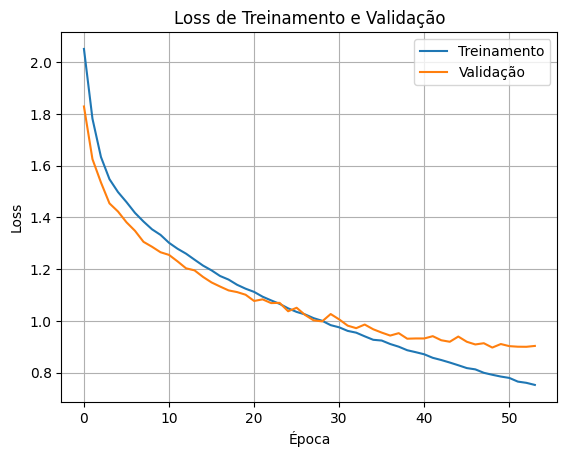

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model4, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6862, 'balanced_accuracy': np.float64(0.6862), 'precision': 0.6895249081613735, 'recall': 0.6862, 'f1_score': 0.6862434416830232}


Houve uma queda no desempenho com o aumento muito grande do batch_size

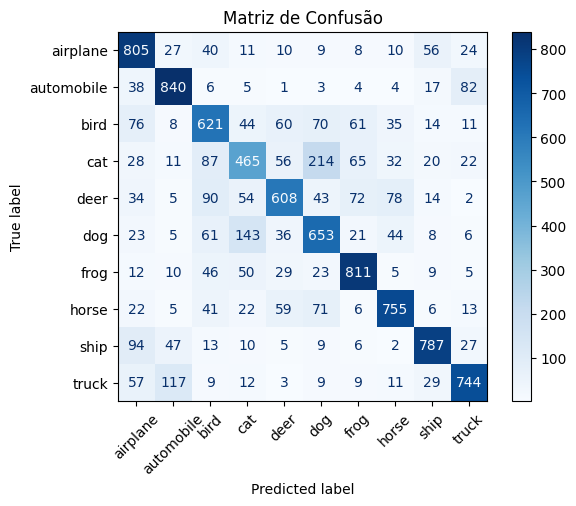

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Mostrar exemplos classificados corretamente e incorretamente

In [ ]:
# Função para desnormalizar e exibir em um subplot (sem plt.show())
def imshow_subplot(ax, img_tensor, title=""):
    img = img_tensor.cpu().numpy()
    # Desnormaliza a imagem
    img = img / 2 + 0.5
    # Converte de (C, H, W) para (H, W, C) para o matplotlib
    img = np.transpose(img, (1, 2, 0))

    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

In [ ]:
# Listas para armazenar os resultados
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []

model1.eval()

# Loop para encontrar as imagens
with torch.no_grad():
    # Itera sobre o loader de teste
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        _, preds = torch.max(outputs, 1)

        # Itera sobre o batch
        for i in range(len(labels)):
            if preds[i] == labels[i] and len(correct_images) < 5:
                correct_images.append(images[i].cpu())
                correct_labels.append(preds[i].cpu())

            # Se a previsão está incorreta E ainda não temos 5
            elif preds[i] != labels[i] and len(incorrect_images) < 5:
                incorrect_images.append(images[i].cpu())
                incorrect_true_labels.append(labels[i].cpu())
                incorrect_pred_labels.append(preds[i].cpu())

            # Condição de parada: para quando ambas as listas estiverem cheias
            if len(correct_images) == 5 and len(incorrect_images) == 5:
                break

        # Para o loop principal também
        if len(correct_images) == 5 and len(incorrect_images) == 5:
            break

print(f"Encontradas {len(correct_images)} imagens corretas e {len(incorrect_images)} imagens incorretas.")


# Exibe as 5 previsões corretas
fig_correct, axes_correct = plt.subplots(1, 5, figsize=(15, 3))
fig_correct.suptitle("5 Previsões Corretas", fontsize=16)

for i, ax in enumerate(axes_correct):
    if i < len(correct_images):
        title = f"Previsto:\n{class_names[correct_labels[i].item()]}"
        imshow_subplot(ax, correct_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta para o super-título
plt.show()


# Exibe as 5 previsões incorretas
fig_incorrect, axes_incorrect = plt.subplots(1, 5, figsize=(15, 4)) # Um pouco mais de altura para o título duplo
fig_incorrect.suptitle("5 Previsões Incorretas", fontsize=16)

for i, ax in enumerate(axes_incorrect):
    if i < len(incorrect_images):
        title = f"Previsto: {class_names[incorrect_pred_labels[i].item()]}\nReal: {class_names[incorrect_true_labels[i].item()]}"
        imshow_subplot(ax, incorrect_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

NameError: name 'model1' is not defined